In [151]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import eli5
from collections import Counter

from sklearn.preprocessing import QuantileTransformer
from sklearn.preprocessing import PowerTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.impute import SimpleImputer
from imblearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

from sklearn.utils.class_weight import compute_class_weight
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold

from imblearn.over_sampling import SMOTE
from imblearn.combine import SMOTETomek
from imblearn.under_sampling import TomekLinks
from sklearn.ensemble import RandomForestClassifier
from imblearn.ensemble import BalancedRandomForestClassifier

from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import fbeta_score
from sklearn.metrics import make_scorer
from sklearn.metrics import roc_auc_score
from sklearn.metrics import plot_roc_curve
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import roc_curve

In [152]:
X = pd.read_csv('X.csv')
# X = pd.read_csv('s3://cxa-lc-data/X.csv')

y = pd.read_csv('y.csv')
# y = pd.read_csv('s3://cxa-lc-data/y.csv')

y = y.values.ravel()

In [153]:
#Creating just temporary small samples
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.25, stratify=y, random_state=42)

In [154]:
num_transform = Pipeline(steps=[
    ('imputer',SimpleImputer(strategy='median')),
    ('norm', PowerTransformer(method='yeo-johnson', standardize=True))
])

#BOXCOX TRANSFORM
# num_transform = Pipeline(steps=[
#     ('imputer',SimpleImputer(strategy='median')),
#     ('scale', MinMaxScaler([1,2]))
#     ('norm', PowerTransformer(method='box-cox', standardize=True))])

cat_transform = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot',OneHotEncoder(handle_unknown='ignore'))
])

# CONSTANT CAT. IMPUTER
# cat_transform = Pipeline(steps=[
#     ('imputer', SimpleImputer(strategy='constant',fill_value='missing')),
#     ('onehot',OneHotEncoder(handle_unknown='ignore'))
# ])

In [155]:
num_ix = X.select_dtypes(['float64','int64']).columns
cat_ix = X.select_dtypes(['O']).columns

In [156]:
#Build out the column transformer

t= [
    ('categorical',cat_transform,cat_ix),
    ('numerical',num_transform,num_ix),
]

ct = ColumnTransformer(transformers=t,remainder='passthrough')

In [157]:
#Define metric used
F2 = make_scorer(fbeta_score, beta=2)
metric = F2
# metric = 'roc_auc'

In [158]:
samp_size = 5000

In [159]:
X_samp = X_train.sample(samp_size,random_state=42)

In [160]:
y_samp = pd.Series(y_train).sample(samp_size,random_state=42).to_numpy()

In [161]:
X_tsamp = X_test.sample(samp_size,random_state=42)
y_tsamp = pd.Series(y_test).sample(samp_size,random_state=42).to_numpy()

In [162]:
#gridsearch class_weight: balanced, balanced_subsample

#model = BalancedRandomForestClassifier(n_estimators=10)

## Base RF

In [163]:
%%time

model = RandomForestClassifier()

pipe = Pipeline(steps=[
    ('preprocess',ct),
    ('model', model)
])

cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=2, random_state=42)

param_grid = {'model__max_features': ['auto']}

grid = GridSearchCV(estimator=pipe, param_grid=param_grid, n_jobs=-1, cv=cv, scoring=metric, verbose=1) 

grid_result = grid.fit(X_samp, y_samp)

print(f'Best score:{grid_result.best_score_}')
print(f'Best params:{grid_result.best_params_}')

# scores = cross_val_score(pipe, X_samp, y_samp, scoring=metric, cv=cv, n_jobs=-1)
 

Fitting 20 folds for each of 1 candidates, totalling 20 fits
Best score:0.8315098849186867
Best params:{'model__max_features': 'auto'}
CPU times: user 1.29 s, sys: 179 ms, total: 1.47 s
Wall time: 8.1 s


In [164]:
pred = grid.predict(X_tsamp)

conf_matx = confusion_matrix(y_tsamp, pred)

print(conf_matx) 

classif_report = classification_report(y_tsamp,pred,digits=3)

print(classif_report)

[[4360   18]
 [ 110  512]]
              precision    recall  f1-score   support

           0      0.975     0.996     0.986      4378
           1      0.966     0.823     0.889       622

    accuracy                          0.974      5000
   macro avg      0.971     0.910     0.937      5000
weighted avg      0.974     0.974     0.974      5000



Precision: 0.9754
Recall: 0.9959
AUROC: 0.910


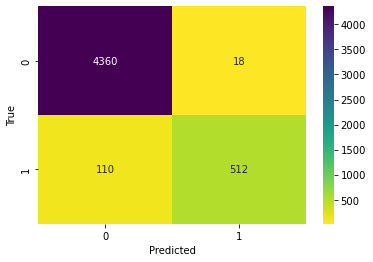

In [165]:
true_pos = conf_matx[0][0]
false_pos = conf_matx[1][0]
true_neg = conf_matx[1][1]
false_neg = conf_matx[0][1]

precision = true_pos/(true_pos + false_pos)

recall = true_pos/(true_pos + false_neg)

auroc = roc_auc_score(y_tsamp,pred)

print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'AUROC: {auroc:.3f}')

ax = sns.heatmap(conf_matx, cmap='viridis_r', annot=True, fmt='d')
ax.set_xlabel('Predicted')
ax.set_ylabel('True')
plt.show()


Predicting all majority class: 0.8756
Random Forest ROC AUC: 0.9095
Best F2 Score: 0.8315


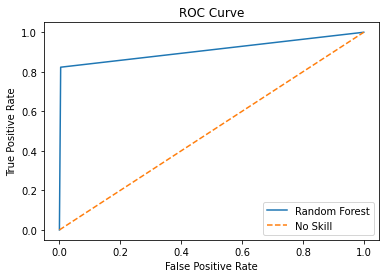

In [166]:
#Evaluating on F2 Score but just looking at area under ROC curve

print(f'Predicting all majority class: {Counter(y_tsamp)[0]/(Counter(y_tsamp)[0]+Counter(y_tsamp)[1]):.4f}')

print(f'Random Forest ROC AUC: {auroc:.4f}')

print(f'Best F2 Score: {grid.best_score_:.4f}')

fpr, tpr, _ = roc_curve(y_tsamp,pred)


plt.plot(fpr,tpr, label='Random Forest')
plt.plot([0,1],[0,1], linestyle='--', label = 'No Skill')
plt.title('ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()

## Tuned RF

In [167]:
%%time

model_tune = RandomForestClassifier()

pipe_tune = Pipeline(steps=[
    ('preprocess',ct),
    ('model_tune', model_tune)
])

cv_tune = RepeatedStratifiedKFold(n_splits=10, n_repeats=2, random_state=42)

param_grid_tune = [
    {'model_tune__class_weight': ['balanced','balanced_subsample','None'],
     'model_tune__n_estimators': [10,50,100,250,500,1000],
     'model_tune__max_features': ['auto', 'sqrt','None']}
     ]

grid_tune = GridSearchCV(estimator=pipe_tune, param_grid=param_grid_tune, n_jobs=-1, cv=cv_tune, scoring=metric, verbose=1) 

grid_result_tune = grid_tune.fit(X_samp, y_samp)

print(f'Best score:{grid_result_tune.best_score_}')
print(f'Best params:{grid_result_tune.best_params_}')

# scores_tune = cross_val_score(pipe_tune, X_samp, y_samp, scoring=metric, cv=cv_tune, n_jobs=-1)


Fitting 20 folds for each of 54 candidates, totalling 1080 fits


/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:3237: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:3237: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:3237: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:3237: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:3237: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/Users/cxa013/opt/anaconda3/li

/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:3237: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:3237: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:3237: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:3237: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:3237: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/Users/cxa013/opt/anaconda3/li

/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:3237: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:3237: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:3237: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:3237: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:3237: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/Users/cxa013/opt/anaconda3/li

/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:3237: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:3237: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:3237: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:3237: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:3237: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/Users/cxa013/opt/anaconda3/li

/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:3237: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:3237: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:3237: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:3237: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:3237: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/Users/cxa013/opt/anaconda3/li

/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:3237: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:3237: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:3237: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:3237: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:3237: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/Users/cxa013/opt/anaconda3/li

/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:3237: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:3237: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/imblearn/pipeline.py", line 266, in fit
    self._final_estimator.fit(Xt, yt, **fit_params_last_step

/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:3237: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/imblearn/pipeline.py", line 266, in fit
    self._final_estimator.fit(Xt, yt, **fit_params_last_step)
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/Users/cxa

/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:3237: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/imblearn/pipeline.py", line 266, in fit
    self._final_estimator.fit(Xt, yt, **fit_params_last_step)
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/Users/cxa

/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:3237: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/imblearn/pipeline.py", line 266, in fit
    self._final_estimator.fit(Xt, yt, **fit_params_last_step)
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/Users/cxa

/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:3237: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:3237: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:3237: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:3237: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:3237: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/Users/cxa013/opt/anaconda3/li

/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:3237: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/imblearn/pipeline.py", line 266, in fit
    self._final_estimator.fit(Xt, yt, **fit_params_last_step)
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/Users/cxa

/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:3237: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/imblearn/pipeline.py", line 266, in fit
    self._final_estimator.fit(Xt, yt, **fit_params_last_step)
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/Users/cxa

/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:3237: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:3237: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:3237: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:3237: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Deta

/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:3237: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/imblearn/pipeline.py", line 266, in fit
    self._final_estimator.fit(Xt, yt, **fit_params_last_step)
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/Users/cxa

/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:3237: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/imblearn/pipeline.py", line 266, in fit
    self._final_estimator.fit(Xt, yt, **fit_params_last_step)
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/Users/cxa

/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:3237: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/imblearn/pipeline.py", line 266, in fit
    self._final_estimator.fit(Xt, yt, **fit_params_last_step)
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/Users/cxa

/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:3237: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/imblearn/pipeline.py", line 266, in fit
    self._final_estimator.fit(Xt, yt, **fit_params_last_step)
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/Users/cxa

/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:3237: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:3237: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/imblearn/pipeline.py", line 266, in fit
    self._final_estimator.fit(Xt, yt, **fit_params_last_step

/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:3237: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/imblearn/pipeline.py", line 266, in fit
    self._final_estimator.fit(Xt, yt, **fit_params_last_step)
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/Users/cxa

/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:3237: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/imblearn/pipeline.py", line 266, in fit
    self._final_estimator.fit(Xt, yt, **fit_params_last_step)
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/Users/cxa

/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:3237: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/imblearn/pipeline.py", line 266, in fit
    self._final_estimator.fit(Xt, yt, **fit_params_last_step)
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/Users/cxa

/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:3237: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/imblearn/pipeline.py", line 266, in fit
    self._final_estimator.fit(Xt, yt, **fit_params_last_step)
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/Users/cxa

/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:3237: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/imblearn/pipeline.py", line 266, in fit
    self._final_estimator.fit(Xt, yt, **fit_params_last_step)
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/Users/cxa

/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:3237: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/imblearn/pipeline.py", line 266, in fit
    self._final_estimator.fit(Xt, yt, **fit_params_last_step)
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/Users/cxa

/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:3237: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/imblearn/pipeline.py", line 266, in fit
    self._final_estimator.fit(Xt, yt, **fit_params_last_step)
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/Users/cxa

/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:3237: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/imblearn/pipeline.py", line 266, in fit
    self._final_estimator.fit(Xt, yt, **fit_params_last_step)
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/Users/cxa

/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:3237: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/imblearn/pipeline.py", line 266, in fit
    self._final_estimator.fit(Xt, yt, **fit_params_last_step)
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/Users/cxa

/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:3237: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/imblearn/pipeline.py", line 266, in fit
    self._final_estimator.fit(Xt, yt, **fit_params_last_step)
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/Users/cxa

/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:3237: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/imblearn/pipeline.py", line 266, in fit
    self._final_estimator.fit(Xt, yt, **fit_params_last_step)
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/Users/cxa

/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:3237: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/imblearn/pipeline.py", line 266, in fit
    self._final_estimator.fit(Xt, yt, **fit_params_last_step)
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/Users/cxa

/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:3237: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/imblearn/pipeline.py", line 266, in fit
    self._final_estimator.fit(Xt, yt, **fit_params_last_step)
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/Users/cxa

/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:3237: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/imblearn/pipeline.py", line 266, in fit
    self._final_estimator.fit(Xt, yt, **fit_params_last_step)
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/Users/cxa

/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:3237: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/imblearn/pipeline.py", line 266, in fit
    self._final_estimator.fit(Xt, yt, **fit_params_last_step)
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/Users/cxa

/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:3237: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/imblearn/pipeline.py", line 266, in fit
    self._final_estimator.fit(Xt, yt, **fit_params_last_step)
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/Users/cxa

/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:3237: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/imblearn/pipeline.py", line 266, in fit
    self._final_estimator.fit(Xt, yt, **fit_params_last_step)
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/Users/cxa

/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:3237: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:3237: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:3237: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:3237: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:3237: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/Users/cxa013/opt/anaconda3/li

/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:3237: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:3237: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:3237: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:3237: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:3237: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/Users/cxa013/opt/anaconda3/li

/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:3237: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:3237: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:3237: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:3237: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:3237: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/Users/cxa013/opt/anaconda3/li

/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:3237: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:3237: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:3237: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:3237: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:3237: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/Users/cxa013/opt/anaconda3/li

/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:3237: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:3237: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:3237: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:3237: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:3237: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/Users/cxa013/opt/anaconda3/li

/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:3237: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:3237: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:3237: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_

/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:3237: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:3237: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/imblearn/pipeline.py", line 266, in fit
    self._final_estimator.fit(Xt, yt, **fit_params_last_step

/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:3237: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/imblearn/pipeline.py", line 266, in fit
    self._final_estimator.fit(Xt, yt, **fit_params_last_step)
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/Users/cxa

/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:3237: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/imblearn/pipeline.py", line 266, in fit
    self._final_estimator.fit(Xt, yt, **fit_params_last_step)
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/Users/cxa

/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:3237: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/imblearn/pipeline.py", line 266, in fit
    self._final_estimator.fit(Xt, yt, **fit_params_last_step)
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/Users/cxa

/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:3237: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/imblearn/pipeline.py", line 266, in fit
    self._final_estimator.fit(Xt, yt, **fit_params_last_step)
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/Users/cxa

/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:3237: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/imblearn/pipeline.py", line 266, in fit
    self._final_estimator.fit(Xt, yt, **fit_params_last_step)
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/Users/cxa

/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:3237: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/imblearn/pipeline.py", line 266, in fit
    self._final_estimator.fit(Xt, yt, **fit_params_last_step)
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/Users/cxa

  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/joblib/_parallel_backends.py", line 208, in apply_async
    result = ImmediateResult(func)
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/joblib/_parallel_backends.py", line 572, in __init__
    self.results = batch()
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 262, in __call__
    return [func(*args, **kwargs)
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 262, in <listcomp>
    return [func(*args, **kwargs)
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/fixes.py", line 222, in __call__
    return self.function(*args, **kwargs)
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py", line 169, in _parallel_build_trees
    tree.fit(X, y, sample_weight=curr_sample_weight, check_input=False)
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages

/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:3237: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:3237: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:3237: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:3237: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Deta

/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:3237: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/imblearn/pipeline.py", line 266, in fit
    self._final_estimator.fit(Xt, yt, **fit_params_last_step)
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/Users/cxa

/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:3237: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/imblearn/pipeline.py", line 266, in fit
    self._final_estimator.fit(Xt, yt, **fit_params_last_step)
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/Users/cxa

/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:3237: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/imblearn/pipeline.py", line 266, in fit
    self._final_estimator.fit(Xt, yt, **fit_params_last_step)
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/Users/cxa

  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/imblearn/pipeline.py", line 266, in fit
    self._final_estimator.fit(Xt, yt, **fit_params_last_step)
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 1043, in __call__
    if self.dispatch_one_batch(iterator):
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 861, in dispatch_one_batch
    self._dispatch(tasks)
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 779, in _dispatch
    job = self._backend.apply_async(batch, callback=cb)
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/joblib/_parallel_backends.py", line 208, in apply_async
    result = ImmediateResult(func)
  File "/Users/cxa013/opt/anaconda3/lib/python3.

  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 779, in _dispatch
    job = self._backend.apply_async(batch, callback=cb)
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/joblib/_parallel_backends.py", line 208, in apply_async
    result = ImmediateResult(func)
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/joblib/_parallel_backends.py", line 572, in __init__
    self.results = batch()
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 262, in __call__
    return [func(*args, **kwargs)
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 262, in <listcomp>
    return [func(*args, **kwargs)
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/fixes.py", line 222, in __call__
    return self.function(*args, **kwargs)
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py", line 1

/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:3237: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/imblearn/pipeline.py", line 266, in fit
    self._final_estimator.fit(Xt, yt, **fit_params_last_step)
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/Users/cxa

  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py", line 169, in _parallel_build_trees
    tree.fit(X, y, sample_weight=curr_sample_weight, check_input=False)
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/tree/_classes.py", line 903, in fit
    super().fit(
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/tree/_classes.py", line 265, in fit
    raise ValueError("Invalid value for max_features. "
ValueError: Invalid value for max_features. Allowed string values are 'auto', 'sqrt' or 'log2'.

  warnings.warn("Estimator fit failed. The score on this train-test"
/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:3237: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score 

    result = ImmediateResult(func)
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/joblib/_parallel_backends.py", line 572, in __init__
    self.results = batch()
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 262, in __call__
    return [func(*args, **kwargs)
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 262, in <listcomp>
    return [func(*args, **kwargs)
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/fixes.py", line 222, in __call__
    return self.function(*args, **kwargs)
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py", line 169, in _parallel_build_trees
    tree.fit(X, y, sample_weight=curr_sample_weight, check_input=False)
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/tree/_classes.py", line 903, in fit
    super().fit(
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-pac

  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/fixes.py", line 222, in __call__
    return self.function(*args, **kwargs)
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py", line 169, in _parallel_build_trees
    tree.fit(X, y, sample_weight=curr_sample_weight, check_input=False)
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/tree/_classes.py", line 903, in fit
    super().fit(
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/tree/_classes.py", line 265, in fit
    raise ValueError("Invalid value for max_features. "
ValueError: Invalid value for max_features. Allowed string values are 'auto', 'sqrt' or 'log2'.

  warnings.warn("Estimator fit failed. The score on this train-test"
/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:3237: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var(

/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:3237: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/imblearn/pipeline.py", line 266, in fit
    self._final_estimator.fit(Xt, yt, **fit_params_last_step)
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py", line 331, in fit
    y, expanded_class_weight = self._validate_y_class_weight(y)
  File "/Users/cx

  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py", line 169, in _parallel_build_trees
    tree.fit(X, y, sample_weight=curr_sample_weight, check_input=False)
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/tree/_classes.py", line 903, in fit
    super().fit(
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/tree/_classes.py", line 265, in fit
    raise ValueError("Invalid value for max_features. "
ValueError: Invalid value for max_features. Allowed string values are 'auto', 'sqrt' or 'log2'.

  warnings.warn("Estimator fit failed. The score on this train-test"
/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:3237: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score 

/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/imblearn/pipeline.py", line 266, in fit
    self._final_estimator.fit(Xt, yt, **fit_params_last_step)
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 1043, in __call__
    if self.dispatch_one_batch(iterator):
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-package

  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py", line 331, in fit
    y, expanded_class_weight = self._validate_y_class_weight(y)
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py", line 582, in _validate_y_class_weight
    raise ValueError('Valid presets for class_weight include '
ValueError: Valid presets for class_weight include "balanced" and "balanced_subsample".Given "None".

  warnings.warn("Estimator fit failed. The score on this train-test"
/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:3237: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):


    job = self._backend.apply_async(batch, callback=cb)
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/joblib/_parallel_backends.py", line 208, in apply_async
    result = ImmediateResult(func)
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/joblib/_parallel_backends.py", line 572, in __init__
    self.results = batch()
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 262, in __call__
    return [func(*args, **kwargs)
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 262, in <listcomp>
    return [func(*args, **kwargs)
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/fixes.py", line 222, in __call__
    return self.function(*args, **kwargs)
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py", line 169, in _parallel_build_trees
    tree.fit(X, y, sample_weight=curr_sample_weight, check_input=False)
  File 

/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/imblearn/pipeline.py", line 266, in fit
    self._final_estimator.fit(Xt, yt, **fit_params_last_step)
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py", line 331, in fit
    y, expanded_class_weight = self._validate_y_class_weight(y)
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py", line 582, in _validate_y_class_weight
    raise ValueError('Valid presets for class_weight include '
ValueError: Vali

Traceback (most recent call last):
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/imblearn/pipeline.py", line 266, in fit
    self._final_estimator.fit(Xt, yt, **fit_params_last_step)
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py", line 331, in fit
    y, expanded_class_weight = self._validate_y_class_weight(y)
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py", line 582, in _validate_y_class_weight
    raise ValueError('Valid presets for class_weight include '
ValueError: Valid presets for class_weight include "balanced" and "balanced_subsample".Given "None".

  warnings.warn("Estimator fit failed. The score on this train-test"
/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessi

  warnings.warn("Estimator fit failed. The score on this train-test"
/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:3237: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/imblearn/pipeline.py", line 266, in fit
    self._final_estimator.fit(Xt, yt, **fit_params_last_step)
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py", line 331, in fit
    y, expan

/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:3237: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/imblearn/pipeline.py", line 266, in fit
    self._final_estimator.fit(Xt, yt, **fit_params_last_step)
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py", line 331, in fit
    y, expanded_class_weight = self._validate_y_class_weight(y)
  File "/Users/cx

/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:3237: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/imblearn/pipeline.py", line 266, in fit
    self._final_estimator.fit(Xt, yt, **fit_params_last_step)
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py", line 331, in fit
    y, expanded_class_weight = self._validate_y_class_weight(y)
  File "/Users/cx

/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:3237: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/imblearn/pipeline.py", line 266, in fit
    self._final_estimator.fit(Xt, yt, **fit_params_last_step)
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py", line 331, in fit
    y, expanded_class_weight = self._validate_y_class_weight(y)
  File "/Users/cx

  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py", line 331, in fit
    y, expanded_class_weight = self._validate_y_class_weight(y)
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py", line 582, in _validate_y_class_weight
    raise ValueError('Valid presets for class_weight include '
ValueError: Valid presets for class_weight include "balanced" and "balanced_subsample".Given "None".

  warnings.warn("Estimator fit failed. The score on this train-test"
/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:3237: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):


/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:3237: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/imblearn/pipeline.py", line 266, in fit
    self._final_estimator.fit(Xt, yt, **fit_params_last_step)
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py", line 331, in fit
    y, expanded_class_weight = self._validate_y_class_weight(y)
  File "/Users/cx

  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/imblearn/pipeline.py", line 266, in fit
    self._final_estimator.fit(Xt, yt, **fit_params_last_step)
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py", line 331, in fit
    y, expanded_class_weight = self._validate_y_class_weight(y)
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py", line 582, in _validate_y_class_weight
    raise ValueError('Valid presets for class_weight include '
ValueError: Valid presets for class_weight include "balanced" and "balanced_subsample".Given "None".

  warnings.warn("Estimator fit failed. The score on this train-test"
/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:3237: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:615:

/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/imblearn/pipeline.py", line 266, in fit
    self._final_estimator.fit(Xt, yt, **fit_params_last_step)
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py", line 331, in fit
    y, expanded_class_weight = self._validate_y_class_weight(y)
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py", line 582, in _validate_y_class_weight
    raise ValueError('Valid presets for class_weight include '
ValueError: Vali

  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py", line 582, in _validate_y_class_weight
    raise ValueError('Valid presets for class_weight include '
ValueError: Valid presets for class_weight include "balanced" and "balanced_subsample".Given "None".

  warnings.warn("Estimator fit failed. The score on this train-test"
/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:3237: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_

    y, expanded_class_weight = self._validate_y_class_weight(y)
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py", line 582, in _validate_y_class_weight
    raise ValueError('Valid presets for class_weight include '
ValueError: Valid presets for class_weight include "balanced" and "balanced_subsample".Given "None".

  warnings.warn("Estimator fit failed. The score on this train-test"
/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:3237: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 5

  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/imblearn/pipeline.py", line 266, in fit
    self._final_estimator.fit(Xt, yt, **fit_params_last_step)
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py", line 331, in fit
    y, expanded_class_weight = self._validate_y_class_weight(y)
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py", line 582, in _validate_y_class_weight
    raise ValueError('Valid presets for class_weight include '
ValueError: Valid presets for class_weight include "balanced" and "balanced_subsample".Given "None".

  warnings.warn("Estimator fit failed. The score on this train-test"
/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:3237: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:615:

/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:3237: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/imblearn/pipeline.py", line 266, in fit
    self._final_estimator.fit(Xt, yt, **fit_params_last_step)
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py", line 331, in fit
    y, expanded_class_weight = self._validate_y_class_weight(y)
  File "/Users/cx

/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:3237: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/imblearn/pipeline.py", line 266, in fit
    self._final_estimator.fit(Xt, yt, **fit_params_last_step)
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py", line 331, in fit
    y, expanded_class_weight = self._validate_y_class_weight(y)
  File "/Users/cx

  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/imblearn/pipeline.py", line 266, in fit
    self._final_estimator.fit(Xt, yt, **fit_params_last_step)
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py", line 331, in fit
    y, expanded_class_weight = self._validate_y_class_weight(y)
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py", line 582, in _validate_y_class_weight
    raise ValueError('Valid presets for class_weight include '
ValueError: Valid presets for class_weight include "balanced" and "balanced_subsample".Given "None".

  warnings.warn("Estimator fit failed. The score on this train-test"
/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:3237: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:615:

/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:3237: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/imblearn/pipeline.py", line 266, in fit
    self._final_estimator.fit(Xt, yt, **fit_params_last_step)
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py", line 331, in fit
    y, expanded_class_weight = self._validate_y_class_weight(y)
  File "/Users/cx

/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:3237: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/imblearn/pipeline.py", line 266, in fit
    self._final_estimator.fit(Xt, yt, **fit_params_last_step)
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py", line 331, in fit
    y, expanded_class_weight = self._validate_y_class_weight(y)
  File "/Users/cx

/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:3237: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/imblearn/pipeline.py", line 266, in fit
    self._final_estimator.fit(Xt, yt, **fit_params_last_step)
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py", line 331, in fit
    y, expanded_class_weight = self._validate_y_class_weight(y)
  File "/Users/cx

/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:3237: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/imblearn/pipeline.py", line 266, in fit
    self._final_estimator.fit(Xt, yt, **fit_params_last_step)
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py", line 331, in fit
    y, expanded_class_weight = self._validate_y_class_weight(y)
  File "/Users/cx

/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:3237: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/imblearn/pipeline.py", line 266, in fit
    self._final_estimator.fit(Xt, yt, **fit_params_last_step)
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py", line 331, in fit
    y, expanded_class_weight = self._validate_y_class_weight(y)
  File "/Users/cx

/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:3237: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/imblearn/pipeline.py", line 266, in fit
    self._final_estimator.fit(Xt, yt, **fit_params_last_step)
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py", line 331, in fit
    y, expanded_class_weight = self._validate_y_class_weight(y)
  File "/Users/cx

/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:3237: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/imblearn/pipeline.py", line 266, in fit
    self._final_estimator.fit(Xt, yt, **fit_params_last_step)
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py", line 331, in fit
    y, expanded_class_weight = self._validate_y_class_weight(y)
  File "/Users/cx

/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_search.py:922: UserWarning: One or more of the test scores are non-finite: [0.75415342 0.82010514 0.81440629 0.81970502 0.81883507 0.82472269
 0.74667588 0.81153439 0.81880293 0.81656965 0.82347152 0.82285251
        nan        nan        nan        nan        nan        nan
 0.73301887 0.81436152 0.81878229 0.82690496 0.82266004 0.82123783
 0.72516191 0.80052038 0.81960751 0.82899077 0.82221469 0.82190828
        nan        nan        nan        nan        nan        nan
        nan        nan        nan        nan        nan        nan
        nan        nan        nan        nan        nan        nan
        nan        nan        nan        nan        nan        nan]
  warnings.warn(


Best score:0.8289907734286462
Best params:{'model_tune__class_weight': 'balanced_subsample', 'model_tune__max_features': 'sqrt', 'model_tune__n_estimators': 250}
CPU times: user 11.4 s, sys: 4.56 s, total: 16 s
Wall time: 5min 37s


In [168]:
pred_tune = grid_tune.predict(X_tsamp)

conf_matx_tune = confusion_matrix(y_tsamp, pred_tune)

print(conf_matx_tune) 

classif_report_tune = classification_report(y_tsamp,pred_tune,digits=3)

print(classif_report_tune)

[[4369    9]
 [ 122  500]]
              precision    recall  f1-score   support

           0      0.973     0.998     0.985      4378
           1      0.982     0.804     0.884       622

    accuracy                          0.974      5000
   macro avg      0.978     0.901     0.935      5000
weighted avg      0.974     0.974     0.973      5000



Precision: 0.9754
Recall: 0.9959
AUROC: 0.901


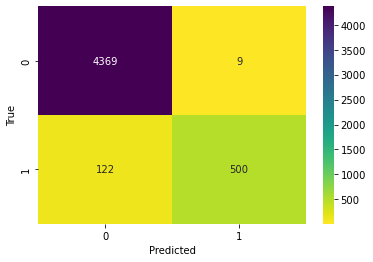

In [169]:
true_pos_tune = conf_matx[0][0]
false_pos_tune = conf_matx[1][0]
true_neg_tune = conf_matx[1][1]
false_neg_tune = conf_matx[0][1]

precision_tune = true_pos_tune/(true_pos_tune + false_pos_tune)

recall_tune = true_pos_tune/(true_pos_tune + false_neg_tune)

auroc_tune = roc_auc_score(y_tsamp,pred_tune)

print(f'Precision: {precision_tune:.4f}')
print(f'Recall: {recall_tune:.4f}')
print(f'AUROC: {auroc_tune:.3f}')

ax_tune = sns.heatmap(conf_matx_tune, cmap='viridis_r', annot=True, fmt='d')
ax_tune.set_xlabel('Predicted')
ax_tune.set_ylabel('True')
plt.show()


Predicting all majority class: 0.8756
Random Forest ROC AUC: 0.9009
Best F2 Score: 0.8290


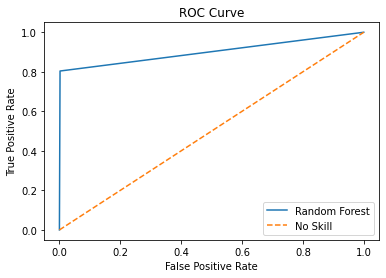

In [170]:
#Evaluating on F2 Score but just looking at area under ROC curve

print(f'Predicting all majority class: {Counter(y_tsamp)[0]/(Counter(y_tsamp)[0]+Counter(y_tsamp)[1]):.4f}')

print(f'Random Forest ROC AUC: {auroc_tune:.4f}')

print(f'Best F2 Score: {grid_tune.best_score_:.4f}')

fpr_tune, tpr_tune, _ = roc_curve(y_tsamp,pred_tune)


plt.plot(fpr_tune,tpr_tune, label='Random Forest')
plt.plot([0,1],[0,1], linestyle='--', label = 'No Skill')
plt.title('ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()

## Feature Importance (Base Model)

In [171]:
feature_import = grid_result.best_estimator_._final_estimator.feature_importances_

In [172]:
#Get feature names
feat_fit = pipe.fit(X_samp, y_samp)
onehot_cat_cols = feat_fit.named_steps['preprocess'].transformers_[0][1].named_steps['onehot'].get_feature_names(cat_ix)

onehot_cat_cols = list(onehot_cat_cols)

features = list(onehot_cat_cols)
features.extend(num_ix)

In [173]:
feat_count = 25

feature_importance = pd.Series(index=features, data=feature_import).nlargest(feat_count)
feature_importance

last_fico_range_high          0.201439
last_fico_range_low           0.114330
total_rec_prncp               0.074029
last_pymnt_amnt               0.058296
last_pymnt_d_rel              0.054660
out_prncp                     0.040127
total_pymnt                   0.033729
last_credit_pull_d_rel        0.031998
funded_amnt                   0.024373
installment                   0.023338
issue_d_rel                   0.021614
loan_amnt                     0.021241
int_rate                      0.012151
total_rec_int                 0.011867
grade_ord                     0.008803
total_rec_late_fee            0.008652
total_rev_hi_lim              0.008058
avg_cur_bal                   0.007944
total_bc_limit                0.007895
dti                           0.007869
revol_bal                     0.007405
mo_sin_old_rev_tl_op          0.007365
annual_inc                    0.007206
total_il_high_credit_limit    0.007114
total_bal_ex_mort             0.007074
dtype: float64

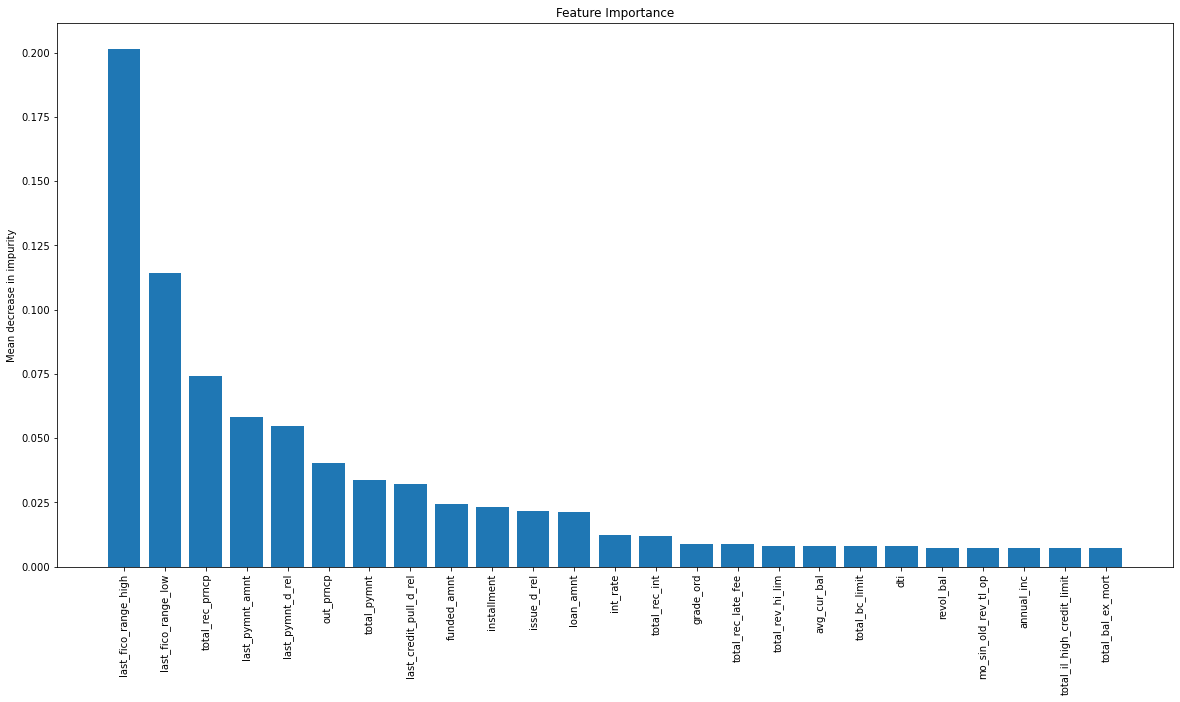

In [174]:
plt.figure(figsize=(20,10))
plt.bar(feature_importance.index,feature_importance.values)
plt.xticks(rotation=90)
plt.title('Feature Importance')
plt.ylabel('Mean decrease in impurity')
plt.show()

In [175]:
eli5.explain_weights(grid_result.best_estimator_['model'], top=feat_count, feature_names = features)

Weight,Feature
0.2014 ± 0.3134,last_fico_range_high
0.1143 ± 0.2229,last_fico_range_low
0.0740 ± 0.1034,total_rec_prncp
0.0583 ± 0.0927,last_pymnt_amnt
0.0547 ± 0.0943,last_pymnt_d_rel
0.0401 ± 0.1301,out_prncp
0.0337 ± 0.0509,total_pymnt
0.0320 ± 0.0876,last_credit_pull_d_rel
0.0244 ± 0.0496,funded_amnt
0.0233 ± 0.0422,installment


In [176]:
pd.set_option('display.max_colwidth', None)
definitions = pd.read_excel('https://resources.lendingclub.com/LCDataDictionary.xlsx',usecols=['LoanStatNew','Description'])

In [177]:
for i in feature_importance.index:
    print(definitions[definitions['LoanStatNew'] == i]['Description'])
    print()

37    The upper boundary range the borrower’s last FICO pulled belongs to.
Name: Description, dtype: object

38    The lower boundary range the borrower’s last FICO pulled belongs to.
Name: Description, dtype: object

109    Principal received to date
Name: Description, dtype: object

39    Last total payment amount received
Name: Description, dtype: object

Series([], Name: Description, dtype: object)

80    Remaining outstanding principal for total amount funded
Name: Description, dtype: object

105    Payments received to date for total amount funded
Name: Description, dtype: object

Series([], Name: Description, dtype: object)

23    The total amount committed to that loan at that point in time.
Name: Description, dtype: object

33    The monthly payment owed by the borrower if the loan originates.
Name: Description, dtype: object

Series([], Name: Description, dtype: object)

41    The listed amount of the loan applied for by the borrower. If at some point in time, the credit depa

In [178]:
#Plot Correlation of the most important features

## Feature Importance (Tuned Model)

In [179]:
feature_import_tune = grid_result_tune.best_estimator_._final_estimator.feature_importances_

In [180]:
feature_importance_tune = pd.Series(index=features, data=feature_import_tune).nlargest(feat_count)
feature_importance_tune

last_fico_range_high      0.197180
last_fico_range_low       0.147495
last_pymnt_d_rel          0.100418
last_pymnt_amnt           0.089911
total_rec_prncp           0.064911
out_prncp                 0.049977
last_credit_pull_d_rel    0.028224
total_pymnt               0.026013
issue_d_rel               0.019784
int_rate                  0.015756
installment               0.013784
funded_amnt               0.011661
loan_amnt                 0.011537
total_rec_int             0.009788
grade_ord                 0.009769
total_rev_hi_lim          0.006868
total_rec_late_fee        0.006358
bc_open_to_buy            0.006233
total_bc_limit            0.005960
dti                       0.005887
fico_range_high           0.005635
fico_range_low            0.005576
mo_sin_old_il_acct        0.005399
total_bal_ex_mort         0.005380
annual_inc                0.005303
dtype: float64

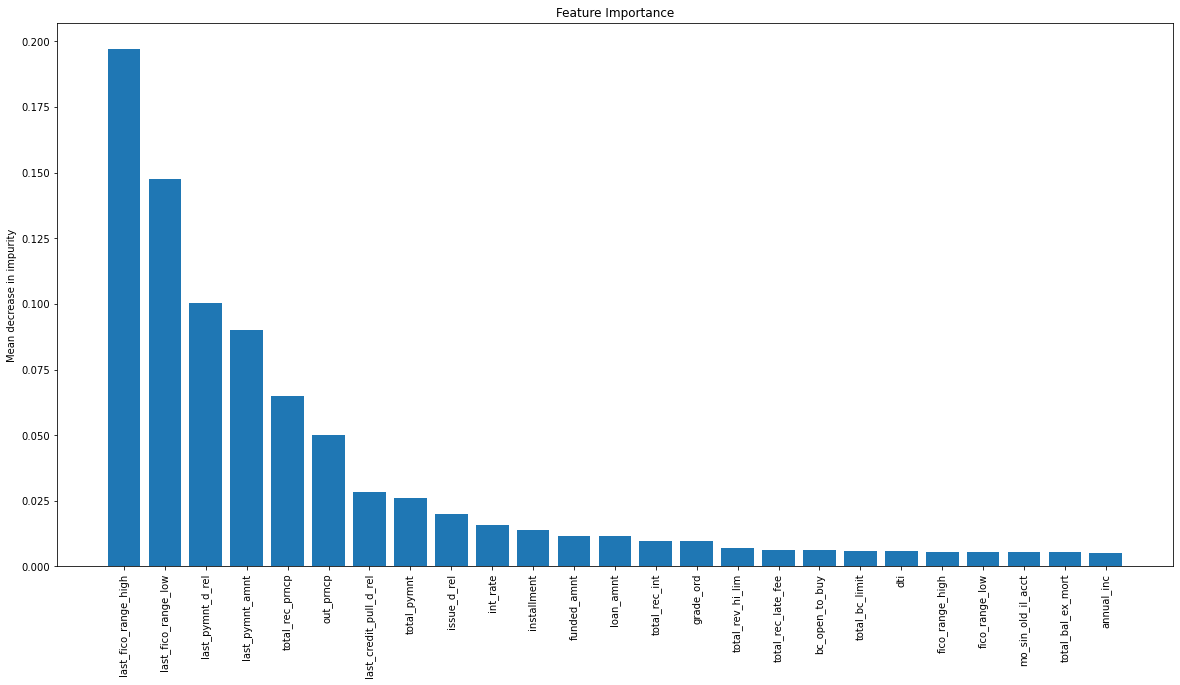

In [181]:
plt.figure(figsize=(20,10))
plt.bar(feature_importance_tune.index,feature_importance_tune.values)
plt.xticks(rotation=90)
plt.title('Feature Importance')
plt.ylabel('Mean decrease in impurity')
plt.show()

In [195]:
eli5.explain_weights(grid_result_tune.best_estimator_['model_tune'], top=feat_count, feature_names = features)

Weight,Feature
0.1972 ± 0.3729,last_fico_range_high
0.1475 ± 0.3183,last_fico_range_low
0.1004 ± 0.1985,last_pymnt_d_rel
0.0899 ± 0.1583,last_pymnt_amnt
0.0649 ± 0.1185,total_rec_prncp
0.0500 ± 0.1377,out_prncp
0.0282 ± 0.0891,last_credit_pull_d_rel
0.0260 ± 0.0608,total_pymnt
0.0198 ± 0.0553,issue_d_rel
0.0158 ± 0.0441,int_rate


In [196]:
for i in feature_importance_tune.index:
    print(definitions[definitions['LoanStatNew'] == i]['Description'])
    print()

37    The upper boundary range the borrower’s last FICO pulled belongs to.
Name: Description, dtype: object

38    The lower boundary range the borrower’s last FICO pulled belongs to.
Name: Description, dtype: object

Series([], Name: Description, dtype: object)

39    Last total payment amount received
Name: Description, dtype: object

109    Principal received to date
Name: Description, dtype: object

80    Remaining outstanding principal for total amount funded
Name: Description, dtype: object

Series([], Name: Description, dtype: object)

105    Payments received to date for total amount funded
Name: Description, dtype: object

Series([], Name: Description, dtype: object)

34    Interest Rate on the loan
Name: Description, dtype: object

33    The monthly payment owed by the borrower if the loan originates.
Name: Description, dtype: object

23    The total amount committed to that loan at that point in time.
Name: Description, dtype: object

41    The listed amount of the loan appl

/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:3237: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/imblearn/pipeline.py", line 266, in fit
    self._final_estimator.fit(Xt, yt, **fit_params_last_step)
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py", line 331, in fit
    y, expanded_class_weight = self._validate_y_class_weight(y)
  File "/Users/cx

/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:3237: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/imblearn/pipeline.py", line 266, in fit
    self._final_estimator.fit(Xt, yt, **fit_params_last_step)
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py", line 331, in fit
    y, expanded_class_weight = self._validate_y_class_weight(y)
  File "/Users/cx

In [ ]:
#Plot Correlation of the most important features

# END